# Regresión Lineal

## 1. Librerias y configuraciones previas


In [1]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np


# Almacenar en caché los resultados de funciones en el disco
# ==============================================================================
import joblib


# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
from scipy import stats
import math

#Separar los datos entrenamiento y prueba
from sklearn.model_selection import train_test_split

#Escalar Variables
from sklearn.preprocessing import MinMaxScaler

#Evaluación del modelo
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

#Creación de modelo
import statsmodels.api as sm
#from sklearn.linear_model import LinearRegression


# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## 2. Funciones

In [2]:
#reload(utils.funciones)

# Funciones externas
# ==============================================================================
from utils.funciones import multiple_plot, plot_roc_curve, tidy_corr_matrix, checkVIF

In [3]:
# Función para contruir un modelo de regresión lineal por medio de statsmodels.api

def build_model(X,y):
    
    #A los datos de entrada 'X' se le adiciona una constante
    X = sm.add_constant(X) 
    
    #Se crea y se entrena el modelo de regresion lineal q(statsmodels.api) con 
    #los datos de entrada 'X' y los datos de salida 'y'
    lm = sm.OLS(y,X).fit()
    
    #imprime el resumen del modelo creado
    print(lm.summary()) # model summary
    
    return X

## 3. Carga del dataset

In [4]:
#Se crea un dataframe d con los datos obtenidos de archivo de entrada
d=pd.read_csv('./datasets/01_carDetailsV4_Prep.csv')

In [5]:
## Cargar datos con colab
## =============================================================================

#from google.colab import drive 
#import os

#drive.mount('/gdrive')

In [6]:
#os.chdir("/gdrive/MyDrive/ModelosCuantitativosPython/Notebooks")
#!ls

In [7]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1441 entries, 0 to 1440
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Price               1441 non-null   float64
 1   Year                1441 non-null   float64
 2   Kilometer           1441 non-null   float64
 3   Engine              1441 non-null   float64
 4   Length              1441 non-null   float64
 5   Width               1441 non-null   float64
 6   Height              1441 non-null   float64
 7   Seating Capacity    1441 non-null   float64
 8   Fuel Tank Capacity  1441 non-null   float64
 9   Fuel Type           1441 non-null   object 
 10  Transmission        1441 non-null   object 
 11  Owner               1441 non-null   object 
 12  Seller Type         1441 non-null   object 
 13  Drivetrain          1441 non-null   object 
 14  PriceRange          1441 non-null   int64  
dtypes: float64(9), int64(1), object(5)
memory usage: 169.0+

## 4. Visualización de datos

### Variables de entrada

In [8]:
#Lista de variables categóricas
catCols = d.select_dtypes(include = ["object", 'category']).columns.tolist()

d[catCols].head(2)

,Fuel Type,Transmission,Owner,Seller Type,Drivetrain
0,Petrol,Automatic,First,Individual,FWD
1,Diesel,Automatic,First,Corporate,AWD


In [9]:
#Lista de variables numéricas

numCols=d.select_dtypes(include = ['float64','float64','int32','int64']).columns.tolist()
d[numCols].head(2)

,Price,Year,Kilometer,Engine,Length,Width,Height,Seating Capacity,Fuel Tank Capacity,PriceRange
0,9540.0,2021.0,9000.0,1199.0,3993.0,1677.0,1532.0,5.0,35.0,1
1,10500.0,2014.0,99000.0,2199.0,4690.0,1880.0,1690.0,7.0,64.0,1


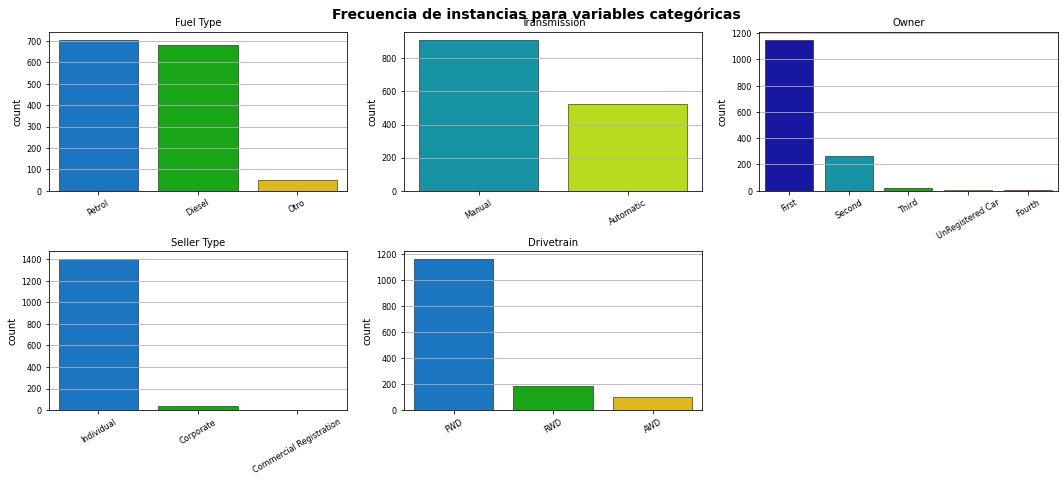

In [10]:
##Visualización de frecuencia de instancias para variables categóricas
multiple_plot(3, d , catCols, None, 'countplot', 'Frecuencia de instancias para variables categóricas',30)

In [11]:
#Visualización por medio de gráficos de caja de bigotes para las variables categóricas con respecto al precio
#multiple_plot(3, d , catCols, 'Price', 'boxplot', 'Distribución de la variable Make vs. el Price',30)

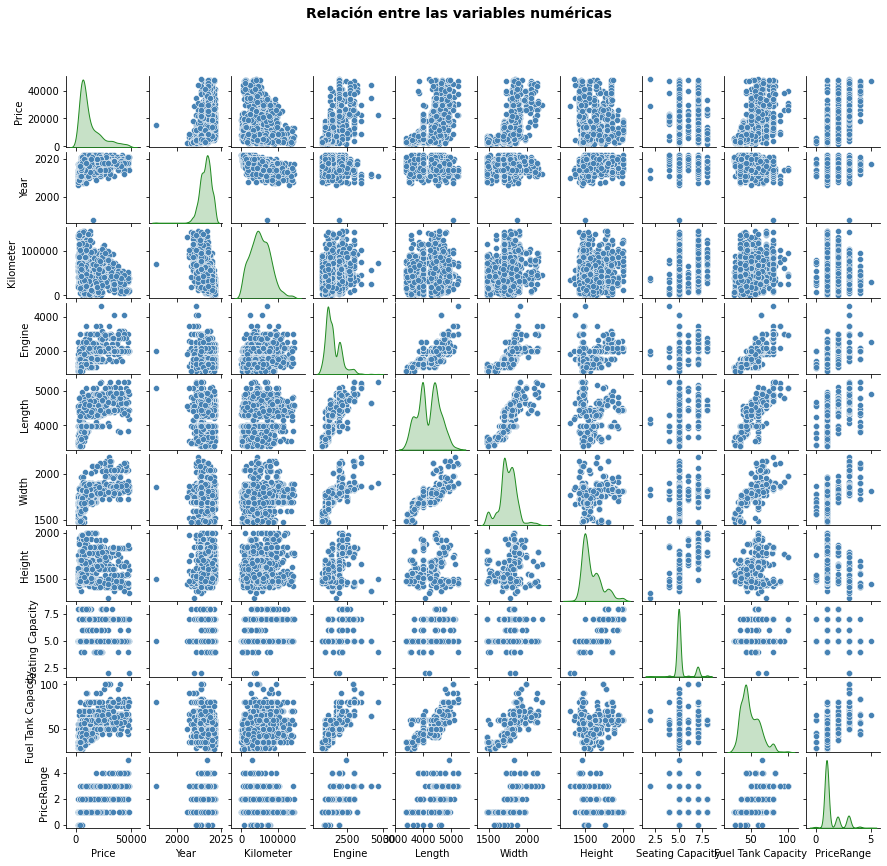

In [12]:
#Visualización de variables numéricas con respecto al precio
multiple_plot(1, d , numCols, None, 'scatterplot', 'Relación entre las variables numéricas',30)

In [13]:
#Eliminar la variable de salida de la lista de variable numéricas
numCols.remove('Price') 

### Variable de salida

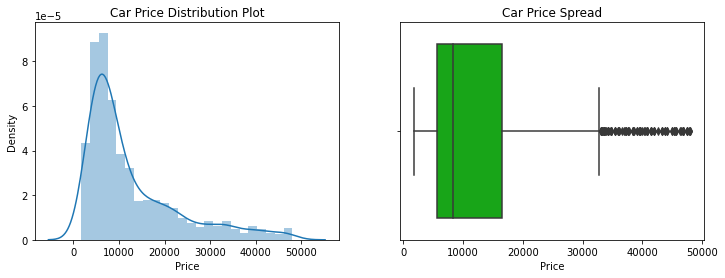

In [14]:
#Histográma y caja de bigotes del precio de los vehículos

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.title('Car Price Distribution Plot')
sns.distplot(d.Price)

plt.subplot(1,2,2)
plt.title('Car Price Spread')
sns.boxplot(x=d.Price, palette='nipy_spectral')

plt.show()

In [15]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)

print(d.Price.describe(percentiles = [0.25,0.50,0.75,0.85,0.90,0.95,0.975,1]))

count    1441
mean    12601
std     10255
min      1740
25%      5580
50%      8388
75%     16500
85%     22500
90%     28800
95%     35880
97.5%   41400
100%    48000
max     48000
Name: Price, dtype: float64


## 6. Preparación de datos

### Transformaciones para la variable de salida

In [16]:
#Tranformacion y = y^(1/3) Raiz cúbica

d['Price'] = np.cbrt(d['Price'])

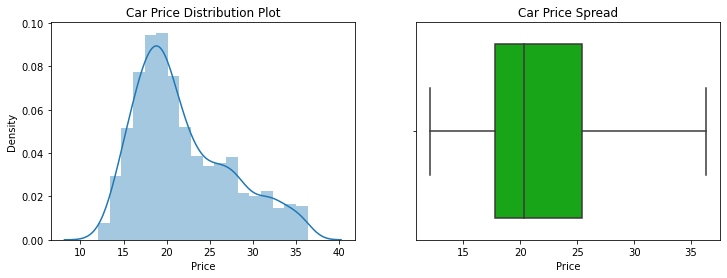

In [17]:
#Histográma y caja de bigotes del precio de los vehículos transformado

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.title('Car Price Distribution Plot')
sns.distplot(d.Price)

plt.subplot(1,2,2)
plt.title('Car Price Spread')
sns.boxplot(x=d.Price, palette='nipy_spectral')

plt.show()

### Transformaciones a las variables de entrada

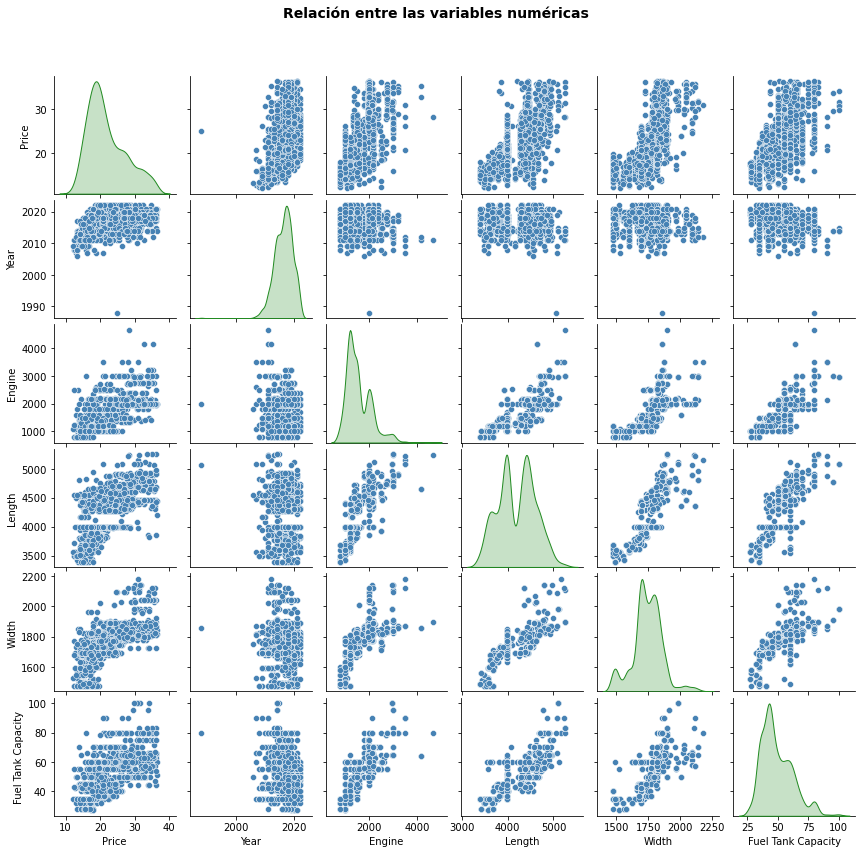

In [18]:
varTrans = ['Price', 'Year','Engine','Length','Width','Fuel Tank Capacity']

multiple_plot(1, d , varTrans, None, 'scatterplot', 'Relación entre las variables numéricas',30)

In [19]:
# Tranformaciones X = X^2 a las variables de entrada

varTrans = ['Year','Length','Width','Fuel Tank Capacity']

for elemento in varTrans:
    d[elemento]   = d[elemento] ** 2
    

### Correlaciones

In [20]:
#Generación de la matriz de correlación
matrizCorr = d.corr()

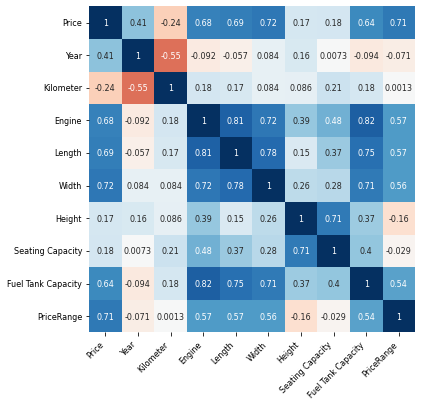

In [21]:
# Mapa de calor (Heatmap) de la matriz de correlaciones

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

sns.heatmap(
    matrizCorr,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = 'RdBu', #sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)


ax.tick_params(labelsize = 8)


In [22]:
#Matriz de correlación ordenada

pd.set_option('display.float_format', lambda x: '%.4f' % x)

#Creación de la matriz
df_corr= tidy_corr_matrix(matrizCorr)

#Selección de las variables correlacionadas con el precio
df_filtrado = df_corr.loc[df_corr['variable_2'] == 'Price']

#Se identifican las correlaciones más fuertes
df_filtrado[df_filtrado['abs_r']>=0.5] 

,variable_1,variable_2,r,abs_r
50,Width,Price,0.7217,0.7217
90,PriceRange,Price,0.7110,0.7110
40,Length,Price,0.6886,0.6886
30,Engine,Price,0.6754,0.6754
80,Fuel Tank Capacity,Price,0.6356,0.6356


In [23]:
#Cantidad de variables más relevantes extraidas a partir de la matriz de correlación ordenada
VarRelevantes = df_filtrado[df_filtrado['abs_r']>=0.5].shape[0]

#Creacion de la lista de variables más relevantes (inicialmente numéricas)
vDep =df_filtrado['variable_1'][:VarRelevantes].tolist()
print(vDep)

['Width', 'PriceRange', 'Length', 'Engine', 'Fuel Tank Capacity']


In [24]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1441 entries, 0 to 1440
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Price               1441 non-null   float64
 1   Year                1441 non-null   float64
 2   Kilometer           1441 non-null   float64
 3   Engine              1441 non-null   float64
 4   Length              1441 non-null   float64
 5   Width               1441 non-null   float64
 6   Height              1441 non-null   float64
 7   Seating Capacity    1441 non-null   float64
 8   Fuel Tank Capacity  1441 non-null   float64
 9   Fuel Type           1441 non-null   object 
 10  Transmission        1441 non-null   object 
 11  Owner               1441 non-null   object 
 12  Seller Type         1441 non-null   object 
 13  Drivetrain          1441 non-null   object 
 14  PriceRange          1441 non-null   int64  
dtypes: float64(9), int64(1), object(5)
memory usage: 169.0+

In [25]:
d.columns

Index(['Price', 'Year', 'Kilometer', 'Engine', 'Length', 'Width', 'Height',
       'Seating Capacity', 'Fuel Tank Capacity', 'Fuel Type', 'Transmission',
       'Owner', 'Seller Type', 'Drivetrain', 'PriceRange'],
      dtype='object')

In [26]:
# Se adiiona a la lista de variables numericas más relevantes todas las variables categóricas
vDep += catCols

vDep

['Width',
 'PriceRange',
 'Length',
 'Engine',
 'Fuel Tank Capacity',
 'Fuel Type',
 'Transmission',
 'Owner',
 'Seller Type',
 'Drivetrain']

In [27]:
d = d[vDep  +['Price']]

In [28]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1441 entries, 0 to 1440
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Width               1441 non-null   float64
 1   PriceRange          1441 non-null   int64  
 2   Length              1441 non-null   float64
 3   Engine              1441 non-null   float64
 4   Fuel Tank Capacity  1441 non-null   float64
 5   Fuel Type           1441 non-null   object 
 6   Transmission        1441 non-null   object 
 7   Owner               1441 non-null   object 
 8   Seller Type         1441 non-null   object 
 9   Drivetrain          1441 non-null   object 
 10  Price               1441 non-null   float64
dtypes: float64(5), int64(1), object(5)
memory usage: 124.0+ KB


### Creación de Variables Dummies

In [29]:
# Aplicación de la función de get_dummies

d =pd.get_dummies(d, drop_first=1)

In [30]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1441 entries, 0 to 1440
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Width                   1441 non-null   float64
 1   PriceRange              1441 non-null   int64  
 2   Length                  1441 non-null   float64
 3   Engine                  1441 non-null   float64
 4   Fuel Tank Capacity      1441 non-null   float64
 5   Price                   1441 non-null   float64
 6   Fuel Type_Otro          1441 non-null   uint8  
 7   Fuel Type_Petrol        1441 non-null   uint8  
 8   Transmission_Manual     1441 non-null   uint8  
 9   Owner_Fourth            1441 non-null   uint8  
 10  Owner_Second            1441 non-null   uint8  
 11  Owner_Third             1441 non-null   uint8  
 12  Owner_UnRegistered Car  1441 non-null   uint8  
 13  Seller Type_Corporate   1441 non-null   uint8  
 14  Seller Type_Individual  1441 non-null   

## 7. Creación del modelo

### Dividir el conjunto de datos

In [31]:
#Se crea un dataframe de prueba de un 10% de los datos
#dPrueba = d.sample(frac=0.1, random_state=321)

#se eliminan los datos de prueba del dataframe
#d = d.drop(index=dPrueba.index)

In [32]:
#Se crea una lista con todas las varibles de entrada

vDep = list(d.columns)
vDep.remove('Price')

#Se establece las variables de entrada 'X' y la variable de salida 'y'
X = d.drop(columns ='Price')
y = d['Price']

In [33]:
# División de los datos en train y test

#En este caso, el 80% de los datos se utilizarán para entrenar el modelo. 

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1), 
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [34]:
#Se establecen las variables numéricas a escalar

#Num_vars contiene la intersección de variables de las listas numCols y vDep
num_vars = list(set(numCols) & set(vDep))

print(num_vars)

['PriceRange', 'Fuel Tank Capacity', 'Length', 'Width', 'Engine']


### Escalar Variables

In [35]:
#Escalar Variables númericas

pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Se crea un objeto MinMaxScaler
scaler = MinMaxScaler()

# Se escalan los valores del dataset entrenamiento y prueba de las columnas numéricas
X_train[num_vars] = scaler.fit_transform(X_train[num_vars])
X_test[num_vars] = scaler.transform(X_test[num_vars])

X_train[num_vars].head()

,PriceRange,Fuel Tank Capacity,Length,Width,Engine
99,0.2000,0.1208,0.1650,0.2239,0.1016
1251,0.2000,0.0690,0.2761,0.3357,0.1044
202,0.2000,0.0535,0.0000,0.0172,0.0008
1418,0.6000,0.3912,0.6497,0.4249,0.3488
254,0.2000,0.1910,0.4337,0.3971,0.1809


In [36]:
X_train.head(2)

,Width,PriceRange,Length,Engine,Fuel Tank Capacity,Fuel Type_Otro,Fuel Type_Petrol,Transmission_Manual,Owner_Fourth,Owner_Second,Owner_Third,Owner_UnRegistered Car,Seller Type_Corporate,Seller Type_Individual,Drivetrain_FWD,Drivetrain_RWD
99,0.2239,0.2000,0.1650,0.1016,0.1208,0,0,1,0,1,0,0,0,1,1,0
1251,0.3357,0.2000,0.2761,0.1044,0.0690,0,1,1,0,0,0,0,0,1,1,0


### Creación del modelo

In [37]:
#Llamamos la funcion build_model definida al principio de este notebook que crea y entrena el modelo

modelo_X_train = build_model(X_train,y_train)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     197.6
Date:                Sun, 14 Apr 2024   Prob (F-statistic):          3.91e-314
Time:                        21:15:37   Log-Likelihood:                -2846.5
No. Observations:                1152   AIC:                             5727.
Df Residuals:                    1135   BIC:                             5813.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     16

Dado que el p-value de `Seller Type_Individual` es mayor a 0.05 no hay suficiente evidencia para sugerir que la variable 
independiente tiene un efecto significativo sobre la variable dependiente

In [38]:
#Se elimina la variable 'Owner_Fourth'
modelo_X_train = modelo_X_train.drop(["Seller Type_Individual"], axis = 1)

In [39]:
#Se crea nuevamente el modelo después de eliminar la variable anterior
modelo_X_train = build_model(modelo_X_train,y_train)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     210.9
Date:                Sun, 14 Apr 2024   Prob (F-statistic):          3.11e-315
Time:                        21:15:37   Log-Likelihood:                -2846.6
No. Observations:                1152   AIC:                             5725.
Df Residuals:                    1136   BIC:                             5806.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     17

In [40]:
#Se elimina la variable 'Fuel Tank Capacity'
modelo_X_train = modelo_X_train.drop(["Fuel Tank Capacity"], axis = 1)

In [41]:
#Se crea nuevamente el modelo después de eliminar la variable anterior
modelo_X_train = build_model(modelo_X_train,y_train)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     226.0
Date:                Sun, 14 Apr 2024   Prob (F-statistic):          2.38e-316
Time:                        21:15:37   Log-Likelihood:                -2846.8
No. Observations:                1152   AIC:                             5724.
Df Residuals:                    1137   BIC:                             5799.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     17

In [42]:
#Se elimina la variable 'Seller Type_Corporate'
modelo_X_train = modelo_X_train.drop(["Seller Type_Corporate"], axis = 1)

In [43]:
#Se crea nuevamente el modelo después de eliminar la variable anterior
modelo_X_train = build_model(modelo_X_train,y_train)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     243.3
Date:                Sun, 14 Apr 2024   Prob (F-statistic):          2.88e-317
Time:                        21:15:37   Log-Likelihood:                -2847.5
No. Observations:                1152   AIC:                             5723.
Df Residuals:                    1138   BIC:                             5794.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     17

In [44]:
#Se elimina la variable 'Fuel Type_Otro'
modelo_X_train = modelo_X_train.drop(["Fuel Type_Otro"], axis = 1)

In [45]:
#Se crea nuevamente el modelo después de eliminar la variable anterior
modelo_X_train = build_model(modelo_X_train,y_train)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     263.2
Date:                Sun, 14 Apr 2024   Prob (F-statistic):          3.90e-318
Time:                        21:15:37   Log-Likelihood:                -2848.3
No. Observations:                1152   AIC:                             5723.
Df Residuals:                    1139   BIC:                             5788.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     17

In [46]:
#Se elimina la variable 'Owner_UnRegistered Car'
modelo_X_train = modelo_X_train.drop(["Owner_UnRegistered Car"], axis = 1)

In [47]:
#Se crea nuevamente el modelo después de eliminar la variable anterior
modelo_X_train = build_model(modelo_X_train,y_train)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     286.5
Date:                Sun, 14 Apr 2024   Prob (F-statistic):          9.26e-319
Time:                        21:15:37   Log-Likelihood:                -2849.7
No. Observations:                1152   AIC:                             5723.
Df Residuals:                    1140   BIC:                             5784.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  17.5509    

### Colinealidad

In [48]:
#Se aplica la funcion de Factor de Inflación de la Varianza (VIF- Variance Inflation Factor) para identificar colinealidad 
#entre las variables

checkVIF(modelo_X_train)

,Features,VIF
0,const,54.7900
4,Engine,5.1300
3,Length,4.4800
10,Drivetrain_FWD,4.1700
1,Width,2.9800
11,Drivetrain_RWD,2.6700
2,PriceRange,2.0300
6,Transmission_Manual,1.6400
5,Fuel Type_Petrol,1.3400
8,Owner_Second,1.0600


Si existe alguna *feature* > 10 debe eliminarse. Siendo estrictos se debe eliminar aquellas variables con VIF > 5.

**Importante:**: Posteriormente a la eliminación, debe verificarse los *p-values* menores a 0.05 nuevamente.

In [49]:
#Se elimina la variable 'Engine'
modelo_X_train = modelo_X_train.drop(["Engine"], axis = 1)

In [50]:
#Se crea nuevamente el modelo después de eliminar la variable anterior
modelo_X_train = build_model(modelo_X_train,y_train)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     313.0
Date:                Sun, 14 Apr 2024   Prob (F-statistic):          1.20e-318
Time:                        21:15:38   Log-Likelihood:                -2852.9
No. Observations:                1152   AIC:                             5728.
Df Residuals:                    1141   BIC:                             5783.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  18.1979    

In [51]:
checkVIF(modelo_X_train)

,Features,VIF
0,const,45.6700
9,Drivetrain_FWD,3.1500
1,Width,2.9700
3,Length,2.8600
10,Drivetrain_RWD,2.6200
2,PriceRange,2.0300
5,Transmission_Manual,1.6400
4,Fuel Type_Petrol,1.3100
7,Owner_Second,1.0600
6,Owner_Fourth,1.0100


In [52]:
#Se crea nuevamente el modelo con las variables anteriormente


#Se crea y se entrena el modelo de regresion lineal q(statsmodels.api)
modelLRegresion  = sm.OLS(y_train,modelo_X_train).fit()

#No es necesario adicionar la constante porque los datos devuelos en la variable 'modelo_X_train' ya contiene la constante

In [53]:
# Si se creara el modelo en sklearn

#from sklearn.linear_model import LinearRegression

# Crear un modelo de regresión lineal
#modeloLR = LinearRegression()

#modeloLR.fit(modelo_X_train, y_train)

## 8. Evaluación del modelo

### Entrenamiento

In [54]:
# Diagnóstico errores (residuos) de las predicciones de entrenamiento

#Reducción de dimensionalidad del dataset: se convierte en una dimensión
y_train = y_train.flatten()

#Se realiza la predicción sobre los datos de entrenamiento
prediccion_train = modelLRegresion.predict(modelo_X_train)

#Se calculan los residuos: diferencia entre la prediccion y el valor real en los datos de entreanamiento 
residuos_train   = prediccion_train - y_train

In [55]:
# Error de Entrenamiento del modelo 


predicciones = modelLRegresion.predict(modelo_X_train)

mse = mean_squared_error (y_true  = y_train, y_pred  = predicciones, squared = True)
rmse = mean_squared_error (y_true  = y_train, y_pred  = predicciones, squared = False)
MAE = mean_absolute_error (y_true  = y_train, y_pred  = predicciones)
MedAE = median_absolute_error (y_true  = y_train, y_pred  = predicciones)
r2 = r2_score (y_true  = y_train, y_pred  = predicciones)

print(f"El error MSE   de train es: {mse}")
print(f"El error RMSE  de train es: {rmse}")
print(f"El error MAE   de train es: {MAE}")
print(f"El error MedAE de train es: {MedAE}")
print(f"El error R2    de train es: {r2}")

El error MSE   de train es: 8.29040121179664
El error RMSE  de train es: 2.8793056822429675
El error MAE   de train es: 2.1887166177478496
El error MedAE de train es: 1.6773027110996699
El error R2    de train es: 0.732848630833265


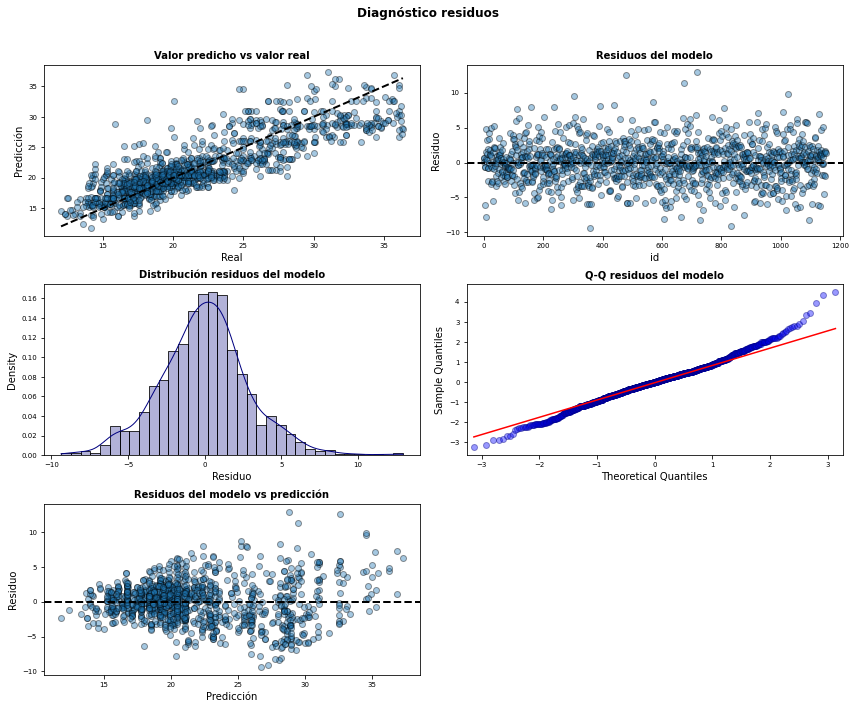

In [56]:
# Gráficos para el pronóstico de residuos

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

axes[0, 0].scatter(y_train, prediccion_train, edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
                'k--', color = 'black', lw=2)
axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 10, fontweight = "bold")
axes[0, 0].set_xlabel('Real')
axes[0, 0].set_ylabel('Predicción')
axes[0, 0].tick_params(labelsize = 7)

axes[0, 1].scatter(list(range(len(y_train))), residuos_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[0, 1].set_title('Residuos del modelo', fontsize = 10, fontweight = "bold")
axes[0, 1].set_xlabel('id')
axes[0, 1].set_ylabel('Residuo')
axes[0, 1].tick_params(labelsize = 7)

sns.histplot(
    data    = residuos_train,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   =  "navy",#"firebrick",
    alpha   = 0.3,
    ax      = axes[1, 0]
)

axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 10,
                     fontweight = "bold")
axes[1, 0].set_xlabel("Residuo")
axes[1, 0].tick_params(labelsize = 7)


sm.qqplot(
    residuos_train,
    fit   = True,
    line  = 'q',
    ax    = axes[1, 1], 
    color = 'navy', #'firebrick',
    alpha = 0.4,
    lw    = 2
)
axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 10, fontweight = "bold")
axes[1, 1].tick_params(labelsize = 7)

axes[2, 0].scatter(prediccion_train, residuos_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[2, 0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize = 10, fontweight = "bold")
axes[2, 0].set_xlabel('Predicción')
axes[2, 0].set_ylabel('Residuo')
axes[2, 0].tick_params(labelsize = 7)

# Se eliminan los axes vacíos
fig.delaxes(axes[2,1])

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Diagnóstico residuos', fontsize = 12, fontweight = "bold");

### Test

In [57]:
#Se extraen solo las columnas que finalmente quedaron en X_train (excluyendo constante)
X_test = X_test[modelo_X_train.columns[1:len(modelo_X_train)]] 

#Adicionamos la constante
X_test = sm.add_constant(X_test)

In [58]:
# Error de Entrenamiento del modelo 


predicciones = modelLRegresion.predict(X_test)

mse = mean_squared_error (y_true  = y_test, y_pred  = predicciones, squared = True)
rmse = mean_squared_error (y_true  = y_test, y_pred  = predicciones, squared = False)
MAE = mean_absolute_error (y_true  = y_test, y_pred  = predicciones)
MedAE = median_absolute_error (y_true  = y_test, y_pred  = predicciones)
r2 = r2_score (y_true  = y_test, y_pred  = predicciones)

print(f"El error MSE   de test es: {mse}")
print(f"El error RMSE  de test es: {rmse}")
print(f"El error MAE   de test es: {MAE}")
print(f"El error MedAE de test es: {MedAE}")
print(f"El error R2    de test es: {r2}")

El error MSE   de test es: 7.428655026106767
El error RMSE  de test es: 2.7255559113888617
El error MAE   de test es: 2.1438733299203405
El error MedAE de test es: 1.772445721015366
El error R2    de test es: 0.7523396480233148


In [59]:
X_test

,const,Width,PriceRange,Length,Fuel Type_Petrol,Transmission_Manual,Owner_Fourth,Owner_Second,Owner_Third,Drivetrain_FWD,Drivetrain_RWD
1339,1.0000,0.0000,0.2000,0.0983,1,1,0,0,0,1,0
418,1.0000,0.0000,0.2000,0.0622,0,1,0,0,0,1,0
1202,1.0000,0.2758,0.2000,0.4715,0,1,0,0,0,1,0
1292,1.0000,0.3833,0.2000,0.4177,1,1,0,0,0,1,0
1006,1.0000,0.2048,0.2000,0.0938,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1377,1.0000,0.2745,0.2000,0.4791,1,0,0,0,0,1,0
1343,1.0000,0.7731,0.6000,0.5176,0,0,0,1,0,0,1
71,1.0000,0.0000,0.2000,0.0983,1,1,0,0,0,1,0
1188,1.0000,0.3209,0.2000,0.2712,1,1,0,0,0,1,0


In [60]:
modelLRegresion.predict(X_test)

1339   15.5383
418    16.0174
1202   20.4158
1292   20.4009
1006   17.9186
         ...  
1377   22.2860
1343   30.5928
71     15.5383
1188   19.1356
642    15.6862
Length: 289, dtype: float64

In [61]:
# Concatenar X_test y y_test
df_prep = pd.DataFrame(np.c_[X_test, y_test], columns= X_test.columns.tolist()+['PriceReal'])
df_prep

,const,Width,PriceRange,Length,Fuel Type_Petrol,Transmission_Manual,Owner_Fourth,Owner_Second,Owner_Third,Drivetrain_FWD,Drivetrain_RWD,PriceReal
0,1.0000,0.0000,0.2000,0.0983,1.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,15.6595
1,1.0000,0.0000,0.2000,0.0622,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,15.5775
2,1.0000,0.2758,0.2000,0.4715,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,18.6434
3,1.0000,0.3833,0.2000,0.4177,1.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,24.1587
4,1.0000,0.2048,0.2000,0.0938,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,18.7008
...,...,...,...,...,...,...,...,...,...,...,...,...
284,1.0000,0.2745,0.2000,0.4791,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,16.8546
285,1.0000,0.7731,0.6000,0.5176,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,31.6817
286,1.0000,0.0000,0.2000,0.0983,1.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,14.6123
287,1.0000,0.3209,0.2000,0.2712,1.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,19.1475


In [62]:
# Predecir los valores para df_prep utilizando el modelLRegresion y Elevar al cubo usando np.power()
resultadoPredict =np.power(modelLRegresion.predict(df_prep.drop(columns ='PriceReal')), 3)
resultadoPredict

0      3751.5829
1      4109.3971
2      8509.4562
3      8490.8451
4      5753.2812
         ...    
284   11068.6687
285   28632.4388
286    3751.5829
287    7006.8982
288    3859.7103
Length: 289, dtype: float64

In [63]:
# Convertir el array numpy resultadoPredic en un DataFrame de pandas
resultadoPredict_df = pd.DataFrame(resultadoPredict, columns=['PricePredict'])
resultadoPredict_df

,PricePredict
0,3751.5829
1,4109.3971
2,8509.4562
3,8490.8451
4,5753.2812
...,...
284,11068.6687
285,28632.4388
286,3751.5829
287,7006.8982


In [64]:
# Concatenar x_i con el DataFrame de las predicciones
concatenated_df = pd.concat([df_prep.reset_index(drop=True), resultadoPredict_df], axis=1)

# el precio real se eleva al cubo
concatenated_df['PriceReal'] = np.power(concatenated_df['PriceReal'],3)

In [65]:
concatenated_df['dif'] = (concatenated_df['PriceReal'] - concatenated_df['PricePredict']).abs()


concatenated_df[['PriceReal', 'PricePredict', 'dif']].sort_values(by='dif', ascending=False)

,PriceReal,PricePredict,dif
95,9000.0000,31244.3757,22244.3757
76,40500.0000,19640.4070,20859.5930
193,43800.0000,23070.2669,20729.7331
105,31200.0000,49548.4807,18348.4807
8,34800.0000,18825.6838,15974.3162
...,...,...,...
114,12900.0000,12965.9141,65.9141
70,6300.0000,6346.7116,46.7116
132,5040.0000,4993.5650,46.4350
287,7020.0000,7006.8982,13.1018


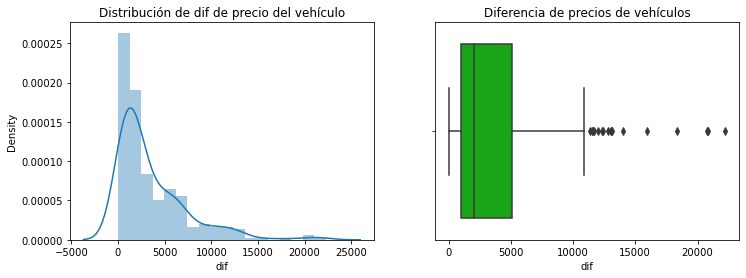

In [66]:
#Histográma y caja de bigotes del precio de los vehículos

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.title('Distribución de dif de precio del vehículo')
sns.distplot(concatenated_df['dif'])

plt.subplot(1,2,2)
plt.title('Diferencia de precios de vehículos')
sns.boxplot(x=concatenated_df['dif'], palette='nipy_spectral')

plt.show()

In [67]:
print(concatenated_df['dif'].describe())

count     289.0000
mean     3575.7850
std      3841.9799
min        12.7141
25%       972.2750
50%      2077.9979
75%      5088.1815
max     22244.3757
Name: dif, dtype: float64


#### Referencias

- *Regresion Lineal en Python:* 
    - https://www.cienciadedatos.net/documentos/py10-regresion-lineal-python.html
  
  
- *Machine learning con Python y Scikit-learn:*
    - https://www.cienciadedatos.net/documentos/py06_machine_learning_python_scikitlearn.html
    

- *scikit-learn:*    
    - https://scikit-learn.org/stable/
    - https://scikit-learn.org/stable/user_guide.html
  
  
- *Recursive Feature Elimination (RFE)*:
    - https://www.kaggle.com/goyalshalini93/car-price-prediction-linear-regression-rfe
    - https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html


- *Gráficas con  seaborn:*
    - https://ichi.pro/es/como-utilizar-python-seaborn-para-analisis-de-datos-exploratorios-28897898172180


- *Multicolinealidad:*
    - https://www.analyticslane.com/2020/04/22/solucionar-la-multicolinealidad-con-vif/


- *Analítica de grandes datos:*
    - https://jdvelasq.github.io/courses/analitica-de-grandes-datos/index.html